In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
###############################################################################
# 1) ENVIRONMENT 
###############################################################################

In [3]:
class RealRelayEnv:
   
    def __init__(self):
        self.n_relays = 14
        self.action_dim = 2 * self.n_relays  # TMS + Ip

        # TMS, Ip bounds
        self.TMS_min, self.TMS_max = 0.05, 2.0
        self.Ip_min,  self.Ip_max  = 400.0, 800.0

        # Main/Backup pairs
        self.main_backup_pairs = [
            (1, 6), (2, 1), (2, 7), (3, 2), (4, 3), (5, 4),
            (6, 5), (6, 14), (7, 5), (7, 13), (8, 7), (8, 9),
            (9, 10), (10, 11), (11, 12), (12, 13), (12, 14),
            (13, 8), (14, 1), (14, 9)
        ]

        # Fault currents
        self.If_main = np.array([
            3232, 5924, 5924, 3556,
            3783, 2401, 6109, 6093,
            2484, 3883, 3707, 5899,
            2991, 5199
        ], dtype=np.float32)

        self.If_backup = np.array([
            3232,  996, 1890, 3556,
            3783, 2401, 1874, 1890,
            2484, 2344, 3707,  987,
            2991,  996
        ], dtype=np.float32)

        # Default standard inverse
        self.a = 0.14
        self.b = 0.02

        self.CTI = 0.2
        self.big_penalty = 1e4  # to be changed for sensitivity

        # For reward scaling => objective in [0..1]
        self.MAX_OBJ = 200000.0

    def set_standard_inverse(self):
        """Switch environment to standard inverse (a=0.14, b=0.02)."""
        self.a = 0.14
        self.b = 0.02

    def set_very_inverse(self):
        """Switch environment to very inverse (a=13.5, b=1.0)."""
        self.a = 13.5
        self.b = 1.0

    def set_penalty(self, penalty_value):
        """Set big_penalty for sensitivity analysis."""
        self.big_penalty = float(penalty_value)

    def reset(self):
        """
        Single-step => no real 'state' => return dummy [0].
        """
        return np.zeros(1, dtype=np.float32)

    def step(self, action):
        """
        Evaluate single-step => (reward, next_state).
        next_state is dummy zeros(1).
        Reward => 1 - clamp(objective / MAX_OBJ).
        """
        n = self.n_relays
        act = np.array(action, dtype=np.float32).copy()

        # Clip
        for i in range(n):
            act[i]     = np.clip(act[i],     self.TMS_min, self.TMS_max)
            act[n + i] = np.clip(act[n + i], self.Ip_min,  self.Ip_max)

        TMS = act[:n]
        Ip  = act[n:]

        # main times
        t_main = np.zeros(n, dtype=np.float32)
        for i in range(n):
            ratio = (self.If_main[i]/Ip[i])**self.b
            if ratio <= 1:
                t_main[i] = 9999.0
            else:
                t_main[i] = TMS[i]*(self.a/(ratio-1))

        T_total = float(np.sum(t_main))

        # constraints => penalty_count
        penalty_count = 0
        for (m, bkup) in self.main_backup_pairs:
            m_idx = m - 1
            b_idx = bkup - 1
            ratio_b = (self.If_backup[b_idx]/Ip[b_idx])**self.b
            if ratio_b <= 1:
                t_b = 9999.0
            else:
                t_b = TMS[b_idx]*(self.a/(ratio_b-1))

            if (t_b - t_main[m_idx]) < self.CTI:
                penalty_count += 1

        objective = T_total + self.big_penalty * penalty_count
        normed = min(1.0, max(0.0, objective/self.MAX_OBJ))
        reward = 1.0 - normed

        next_state = np.zeros(1, dtype=np.float32)
        return reward, next_state


In [4]:
###############################################################################
# 2)  objective function
###############################################################################

In [5]:
def obj(env, action):
    n = env.n_relays
    act = np.array(action, dtype=np.float32).copy()

    for i in range(n):
        act[i]     = np.clip(act[i], env.TMS_min, env.TMS_max)
        act[n + i] = np.clip(act[n + i], env.Ip_min, env.Ip_max)

    TMS = act[:n]
    Ip  = act[n:]

    t_main = np.zeros(n, dtype=np.float32)
    for i in range(n):
        ratio = (env.If_main[i]/Ip[i])**env.b
        if ratio<=1:
            t_main[i]=9999.0
        else:
            t_main[i]= TMS[i]*(env.a/(ratio-1))

    T_total = float(np.sum(t_main))
    penalty_count=0
    for (m,bkup) in env.main_backup_pairs:
        m_idx = m-1
        b_idx = bkup-1
        ratio_b= (env.If_backup[b_idx]/Ip[b_idx])**env.b
        t_b=9999.0 if ratio_b<=1 else (TMS[b_idx]*(env.a/(ratio_b-1)))
        if (t_b - t_main[m_idx])<env.CTI:
            penalty_count+=1

    objective= T_total + env.big_penalty*penalty_count
    return objective, penalty_count



In [6]:
###############################################################################
# 3) EPSILON-GREEDY 
###############################################################################

In [7]:
def epsilon_greedy(env, n_episodes=500, eps_start=1.0, eps_end=0.01, eps_decay=0.99):
    
    n = env.n_relays
    action_dim = env.action_dim

    # random init best
    best_action = np.concatenate([
        np.random.uniform(env.TMS_min, env.TMS_max, n),
        np.random.uniform(env.Ip_min,  env.Ip_max,  n)
    ]).astype(np.float32)

    best_obj, _ = obj(env, best_action)
    best_rew, _ = env.step(best_action)

    all_rewards = np.zeros(n_episodes, dtype=np.float32)
    all_objects = np.zeros(n_episodes, dtype=np.float32)

    eps = eps_start
    for ep in range(n_episodes):
        if np.random.rand()<eps:
            # random
            action = np.concatenate([
                np.random.uniform(env.TMS_min, env.TMS_max, n),
                np.random.uniform(env.Ip_min,  env.Ip_max,  n)
            ])
        else:
            # exploit => best + small noise
            noise_scale = 0.01
            noise = np.random.normal(0, noise_scale, size=action_dim)
            action = best_action + noise

        reward, _ = env.step(action)
        objective, _ = obj(env, action)

        if objective<best_obj:
            best_obj = objective
            best_rew = reward
            best_action = action.astype(np.float32)

        all_rewards[ep] = reward
        all_objects[ep] = objective

        eps = max(eps_end, eps*eps_decay)

    avg_rewards = cumulative_average(all_rewards)
    avg_objects = cumulative_average(all_objects)
    return avg_rewards, avg_objects, best_action, best_obj, best_rew

def cumulative_average(vals):
    out = np.zeros_like(vals)
    s=0.0
    for i, v in enumerate(vals):
        s += v
        out[i] = s/(i+1)
    return out


In [8]:
###############################################################################
# 4) SENSITIVITY 
###############################################################################

In [9]:
def run_sensitivity(env, scenario_name, penalty_values, n_episodes=500):
    results = []
    if scenario_name=="Standard Inverse":
        env.set_standard_inverse()
    else:
        env.set_very_inverse()

    for p_val in penalty_values:
        env.set_penalty(p_val)
        avg_rew_arr, avg_obj_arr, bestA, bestObj, bestRew = epsilon_greedy(
            env, n_episodes=n_episodes, eps_start=1.0, eps_end=0.01, eps_decay=0.99
        )
        # final average (the last element)
        final_avg_rew = avg_rew_arr[-1]
        final_avg_obj = avg_obj_arr[-1]
        best_obj_val, best_viol = obj(env, bestA)

        results.append({
            "penalty": p_val,
            "avg_rew_arr": avg_rew_arr,   # entire array for plotting
            "avg_obj_arr": avg_obj_arr,   # entire array for plotting
            "bestObj": best_obj_val,      # numeric
            "bestRew": bestRew,          # numeric
            "finalAvgRew": final_avg_rew,
            "finalAvgObj": final_avg_obj,
            "bestAction": bestA
        })
    return results



In [10]:
###############################################################################
# 5) MAIN => run penalty in [100...100000], print, plot
###############################################################################


SENSITIVITY RESULTS (Standard Inverse):

+-----------+--------------+------------+--------------+--------------+
| Penalty   | bestObj      | bestReward | avgRewardEnd | avgObjEnd    |
+-----------+--------------+------------+--------------+--------------+
|       100 |        3.332 |      0.998 |        0.998 |        4.883 |
|       500 |       10.659 |      0.995 |        0.990 |       20.700 |
|      2000 |       60.427 |      0.970 |        0.956 |       87.762 |
|      5000 |       50.482 |      0.975 |        0.916 |      167.516 |
|     10000 |      200.507 |      0.900 |        0.805 |      390.871 |
|     20000 |      800.369 |      0.600 |        0.489 |     1023.797 |
|     50000 |     1500.524 |      0.250 |        0.096 |     2257.206 |
|    100000 |     3000.526 |      0.000 |        0.000 |     4280.559 |
+-----------+--------------+------------+--------------+--------------+

** Best penalty for Standard Inverse => 100 with bestObj(k)=3.332.

   TMS = [1.7142028  0.48

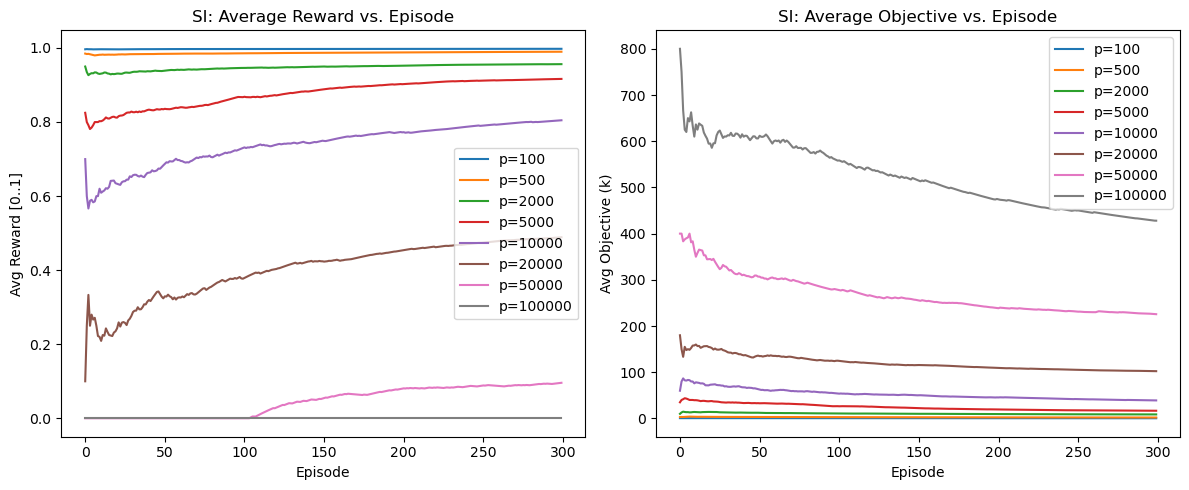

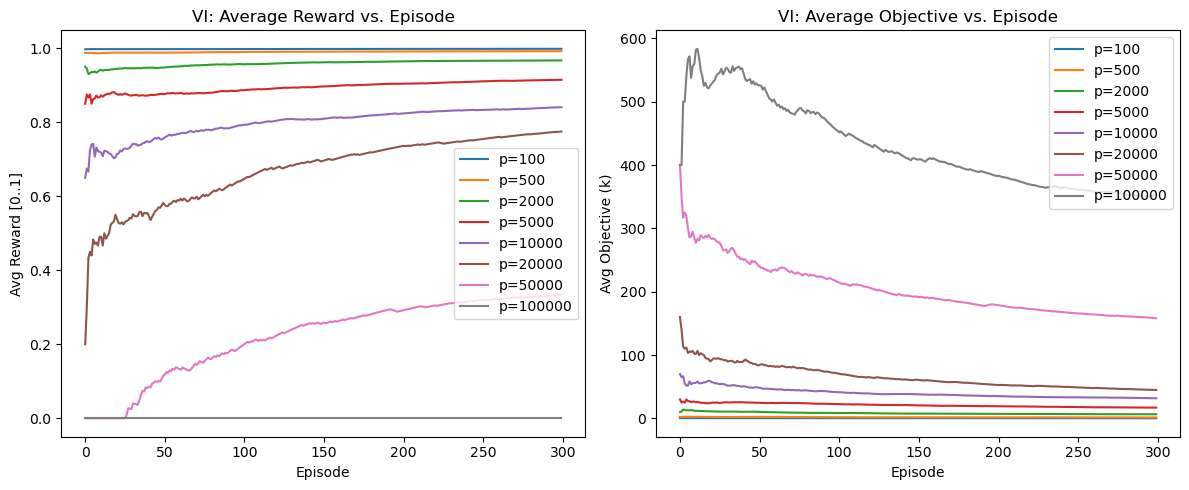

In [12]:
def main():
    env = RealRelayEnv()

    # define penalty values from 100..100000
    penalty_list = [100, 500, 2000, 5000, 10000, 20000, 50000, 100000]

    n_episodes = 300

    # SCENARIO 1: Standard Inverse
    si_results = run_sensitivity(env, "Standard Inverse", penalty_list, n_episodes)

    # SCENARIO 2: Very Inverse
    vi_results = run_sensitivity(env, "Very Inverse", penalty_list, n_episodes)

    def scale_obj(x): return x/100

    #--------------------------
    # TABLE FOR SI
    #--------------------------
    print("\nSENSITIVITY RESULTS (Standard Inverse):\n")
    print("+-----------+--------------+------------+--------------+--------------+")
    print("| Penalty   | bestObj      | bestReward | avgRewardEnd | avgObjEnd    |")
    print("+-----------+--------------+------------+--------------+--------------+")
    bestIdx_si=None
    bestVal_si=float('inf')
    for i, r in enumerate(si_results):
        if r['bestObj']<bestVal_si:
            bestVal_si=r['bestObj']
            bestIdx_si=i

    for r in si_results:
        row = f"| {r['penalty']:>9} | {scale_obj(r['bestObj']):>12.3f} | {r['bestRew']:>10.3f} | {r['finalAvgRew']:>12.3f} | {scale_obj(r['finalAvgObj']):>12.3f} |"
        print(row)
    print("+-----------+--------------+------------+--------------+--------------+")

    best_si = si_results[bestIdx_si]
    print(f"\n** Best penalty for Standard Inverse => {best_si['penalty']} with bestObj(k)={scale_obj(best_si['bestObj']):.3f}.\n")
    n = env.n_relays
    best_TMS_si = best_si["bestAction"][:n]
    best_IP_si  = best_si["bestAction"][n:]
    avg_TMS_si = np.mean(best_TMS_si)
    avg_IP_si  = np.mean(best_IP_si)
    print("   TMS =", best_TMS_si)
    print("   IP  =", best_IP_si)
    print(f"   avg TMS= {avg_TMS_si:.3f}, avg IP= {avg_IP_si:.3f}")


    #--------------------------
    # TABLE FOR VI
    #--------------------------
    print("\nSENSITIVITY RESULTS (Very Inverse):\n")
    print("+-----------+--------------+------------+--------------+--------------+")
    print("| Penalty   | bestObj      | bestReward | avgRewardEnd | avgObjEnd    |")
    print("+-----------+--------------+------------+--------------+--------------+")
    bestIdx_vi=None
    bestVal_vi=float('inf')
    for i, r in enumerate(vi_results):
        if r['bestObj']<bestVal_vi:
            bestVal_vi=r['bestObj']
            bestIdx_vi=i

    for r in vi_results:
        row = f"| {r['penalty']:>9} | {scale_obj(r['bestObj']):>12.3f} | {r['bestRew']:>10.3f} | {r['finalAvgRew']:>12.3f} | {scale_obj(r['finalAvgObj']):>12.3f} |"
        print(row)
    print("+-----------+--------------+------------+--------------+--------------+")

    best_vi = vi_results[bestIdx_vi]
    print(f"\n** Best penalty for Very Inverse => {best_vi['penalty']} with bestObj(k)={scale_obj(best_vi['bestObj']):.3f}.\n")
    best_TMS_vi = best_vi["bestAction"][:n]
    best_IP_vi  = best_vi["bestAction"][n:]
    avg_TMS_vi = np.mean(best_TMS_vi)
    avg_IP_vi  = np.mean(best_IP_vi)
    print("   TMS =", best_TMS_vi)
    print("   IP  =", best_IP_vi)
    print(f"   avg TMS= {avg_TMS_vi:.3f}, avg IP= {avg_IP_vi:.3f}")



    #--------------------------
    # PLOT for SCENARIO 1 (SI) 
    #--------------------------
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    for r in si_results:
        label_str = f"p={r['penalty']}"
        plt.plot(r['avg_rew_arr'], label=label_str)
    plt.xlabel("Episode")
    plt.ylabel("Avg Reward [0..1]")
    plt.title("SI: Average Reward vs. Episode")
    plt.legend()

    plt.subplot(1,2,2)
    for r in si_results:
        label_str = f"p={r['penalty']}"
        plt.plot(r['avg_obj_arr']/1000, label=label_str)
    plt.xlabel("Episode")
    plt.ylabel("Avg Objective (k)")
    plt.title("SI: Average Objective vs. Episode")
    plt.legend()

    plt.tight_layout()
    plt.show()

    #--------------------------
    # PLOT for SCENARIO 2 (VI) 
    #--------------------------
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    for r in vi_results:
        label_str = f"p={r['penalty']}"
        plt.plot(r['avg_rew_arr'], label=label_str)
    plt.xlabel("Episode")
    plt.ylabel("Avg Reward [0..1]")
    plt.title("VI: Average Reward vs. Episode")
    plt.legend()

    plt.subplot(1,2,2)
    for r in vi_results:
        label_str = f"p={r['penalty']}"
        plt.plot(r['avg_obj_arr']/1000, label=label_str)
    plt.xlabel("Episode")
    plt.ylabel("Avg Objective (k)")
    plt.title("VI: Average Objective vs. Episode")
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__=="__main__":
    main()